In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# import torch
# from torch.utils.data import DataLoader
# from torchvision.datasets import VOCDetection
# from torchvision.transforms import functional as F
# from transformers import DetrForObjectDetection, DetrImageProcessor
# from tqdm import tqdm

In [3]:
# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pascal VOC class names (20 + background)
# VOC_CLASSES = [
#     "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow",
#     "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa",
#     "train", "tvmonitor"
# ]
# label2id = {label: i for i, label in enumerate(VOC_CLASSES)}
# id2label = {i: label for label, i in label2id.items()}


In [4]:
# # Processor for DETR
# processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [5]:
# class VOCDataset(torch.utils.data.Dataset):
#     def __init__(self, root, year="2007", image_set="train"):
#         self.voc = VOCDetection(root=root, year=year, image_set=image_set, download=True)

#     def __getitem__(self, idx):
#         img, target = self.voc[idx]
#         w, h = img.size

#         # Handle single vs multiple objects
#         objects = target['annotation']['object']
#         if not isinstance(objects, list):
#             objects = [objects]

#         annotations = []
#         for obj in objects:
#             bbox = obj['bndbox']
#             xmin, ymin, xmax, ymax = float(bbox['xmin']), float(bbox['ymin']), float(bbox['xmax']), float(bbox['ymax'])
#             width = xmax - xmin
#             height = ymax - ymin
#             annotations.append({
#                 "image_id": idx,
#                 "category_id": label2id[obj['name']],
#                 "bbox": [xmin, ymin, width, height],
#                 "area": width * height,
#                 "iscrowd": 0
#             })

#         return img, {"image_id": idx, "annotations": annotations}

#     def __len__(self):
#         return len(self.voc)


In [6]:
# # Instantiate dataset and dataloader
# train_dataset = VOCDataset(root="./", image_set="train")
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: list(zip(*x)))


In [7]:
# # Load DETR model
# model = DetrForObjectDetection.from_pretrained(
#     "facebook/detr-resnet-50",
#     num_labels=len(VOC_CLASSES),
#     ignore_mismatched_sizes=True,  # This avoids error from mismatched classifier head
#     id2label=id2label,
#     label2id=label2id,
# )
# model.to(device)

# # Optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [8]:
# from tqdm import tqdm

# EPOCHS = 2
# model.train()

# # Create the progress bar for the epochs
# for epoch in range(EPOCHS):
#     total_loss = 0
#     # Create a progress bar for the batch loop
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
    
#     for imgs, targets in progress_bar:
#         # Preprocess images and targets
#         inputs = processor(images=imgs, annotations=targets, return_tensors="pt")
#         pixel_values = inputs["pixel_values"].to(device)
#         target_inputs = [{k: v.to(device) for k, v in t.items()} for t in inputs["labels"]]

#         # Forward pass
#         outputs = model(pixel_values=pixel_values, labels=target_inputs)
#         loss = outputs.loss

#         # Backward pass
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
        
#         total_loss += loss.item()

#         # Update the tqdm bar with the current loss
#         progress_bar.set_postfix({"loss": total_loss / (progress_bar.n + 1)})

#     print(f"Epoch {epoch + 1} Loss: {total_loss / len(train_loader):.4f}")


In [9]:
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms

# # Define a transform to preprocess the images (adjust as needed)
# transform = transforms.Compose([
#     transforms.Resize((800, 800)),  # Resize to a consistent size, if necessary
#     transforms.ToTensor(),
# ])

# # Assuming you have a validation dataset class
# # Replace with the actual dataset class you are using
# val_dataset = datasets.VOCDetection(
#     root='path_to_voc', 
#     year='2012', 
#     image_set='val', 
#     download=True,
#     transform=transform
# )

# # Create a DataLoader for validation
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [10]:
# import matplotlib.pyplot as plt
# import torch
# from transformers import DetrImageProcessor, DetrForObjectDetection
# from sklearn.metrics import average_precision_score
# import numpy as np

# # Set model to evaluation mode
# model.eval()

# # Prepare the data
# # Assuming `val_loader` is the DataLoader for the Pascal VOC validation set
# # and the processor has been initialized (DetrImageProcessor)

# # Initialize lists for metrics
# all_preds = []
# all_labels = []
# all_scores = []

# # Iterate over the validation set
# for imgs, targets in tqdm(val_loader, desc="Running Inference"):
#     inputs = processor(images=imgs, annotations=targets, return_tensors="pt")
#     pixel_values = inputs["pixel_values"].to(device)

#     # Run inference
#     with torch.no_grad():
#         outputs = model(pixel_values=pixel_values)

#     # Get predicted boxes and labels
#     logits = outputs.logits  # Shape: [batch_size, num_queries, num_classes]
#     boxes = outputs.pred_boxes  # Shape: [batch_size, num_queries, 4]

#     # Post-process the outputs
#     prob = logits.softmax(-1)  # Convert logits to probabilities
#     prob = prob.squeeze(0)  # If batch size is 1, remove batch dimension
#     pred_labels = prob.argmax(-1)  # Get predicted class labels
#     pred_scores = prob.max(-1).values  # Get the highest score for each prediction

#     # For each image in the batch, draw bounding boxes and labels
#     for i, box in enumerate(boxes):
#         # Post-processing boxes (in the case of only 1 image, use index [0])
#         box = box[i].cpu().numpy()
#         pred_label = pred_labels[i].item()
#         score = pred_scores[i].item()

#         # Draw bounding boxes on the image
#         fig, ax = plt.subplots(1, figsize=(12, 9))
#         ax.imshow(imgs[i].cpu().numpy().transpose(1, 2, 0))

#         # Convert box to (xmin, ymin, xmax, ymax)
#         xmin, ymin, xmax, ymax = box
#         rect = plt.Rectangle(
#             (xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3
#         )
#         ax.add_patch(rect)
#         ax.text(
#             xmin,
#             ymin,
#             f"Class: {pred_label}, Score: {score:.2f}",
#             color="white",
#             fontsize=12,
#             bbox=dict(facecolor="red", alpha=0.5),
#         )
#         plt.show()

#         # Save for metrics calculation
#         all_preds.append(pred_labels.cpu().numpy())
#         all_labels.append(targets['labels'].cpu().numpy())
#         all_scores.append(pred_scores.cpu().numpy())


In [11]:
# from pycocotools import coco

# # Create COCO-style ground truth and prediction objects
# gt_annotations = []
# pred_annotations = []

# for i, (pred, target) in enumerate(zip(all_preds, all_labels)):
#     # Prepare ground truth annotations
#     for j, label in enumerate(target):
#         gt_annotations.append({
#             "image_id": i,
#             "category_id": label,  # Assuming labels are in the COCO format
#             "bbox": [0, 0, 0, 0],  # Example, modify based on your data format
#             "area": 0,  # Similarly, update area
#             "iscrowd": 0,
#         })
    
#     # Prepare predicted annotations
#     for j, pred_label in enumerate(pred):
#         score = all_scores[i][j]
#         pred_annotations.append({
#             "image_id": i,
#             "category_id": pred_label,
#             "bbox": [0, 0, 0, 0],  # Modify based on your post-processing
#             "score": score,
#         })

# # Now calculate mAP using COCO evaluation
# gt_coco = coco.COCO()
# gt_coco.dataset = {"images": [], "annotations": gt_annotations, "categories": []}
# gt_coco.createIndex()

# pred_coco = coco.COCO()
# pred_coco.dataset = {"images": [], "annotations": pred_annotations, "categories": []}
# pred_coco.createIndex()

# # Evaluate the detection results
# coco_eval = coco.COCOeval(gt_coco, pred_coco, iouType="bbox")
# coco_eval.evaluate()
# coco_eval.accumulate()
# coco_eval.summarize()


In [12]:
# import torch
# import matplotlib.pyplot as plt

# # Extract attention weights
# with torch.no_grad():
#     outputs = model(pixel_values=pixel_values)
#     attention = outputs.attentions  # List of attention weights from each layer

# # Choose a particular layer and a particular head (for simplicity)
# layer = 11  # Choose the last layer
# head = 0  # Choose the first attention head

# # Get the attention weights of the selected head in the layer
# attention_weights = attention[layer][0, head]  # Shape: [num_queries, num_keys]

# # Normalize the attention weights for visualization
# attention_weights = attention_weights.cpu().numpy()
# attention_weights = attention_weights - attention_weights.min()
# attention_weights = attention_weights / attention_weights.max()

# # Visualize the attention map
# plt.imshow(attention_weights, cmap='viridis')
# plt.colorbar()
# plt.title(f"Attention Map - Layer {layer}, Head {head}")
# plt.show()


In [13]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection
from torchvision import transforms
from transformers import DetrForObjectDetection, DetrImageProcessor
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


2025-04-24 06:36:11.901536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745476572.068166      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745476572.118185      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pascal VOC classes
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa",
    "train", "tvmonitor"
]
label2id = {label: idx for idx, label in enumerate(VOC_CLASSES)}
id2label = {idx: label for label, idx in label2id.items()}

# Initialize the processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [15]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, year="2007", image_set="train"):
        self.voc = VOCDetection(root=root, year=year, image_set=image_set, download=True)

    def __getitem__(self, idx):
        img, target = self.voc[idx]
        w, h = img.size

        # Handle single vs multiple objects
        objects = target['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]

        annotations = []
        for obj in objects:
            bbox = obj['bndbox']
            xmin = float(bbox['xmin'])
            ymin = float(bbox['ymin'])
            xmax = float(bbox['xmax'])
            ymax = float(bbox['ymax'])
            width = xmax - xmin
            height = ymax - ymin
            annotations.append({
                "image_id": idx,
                "category_id": label2id[obj['name']],
                "bbox": [xmin, ymin, width, height],
                "area": width * height,
                "iscrowd": 0
            })

        return img, {"image_id": idx, "annotations": annotations}

    def __len__(self):
        return len(self.voc)


In [16]:
# Training dataset and loader
train_dataset = VOCDataset(root="./", year="2007", image_set="train")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: list(zip(*x)))

# Validation dataset and loader
val_dataset = VOCDataset(root="./", year="2007", image_set="val")
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: list(zip(*x)))


100%|██████████| 460M/460M [00:19<00:00, 23.1MB/s] 


Extracting ./VOCtrainval_06-Nov-2007.tar to ./
Using downloaded and verified file: ./VOCtrainval_06-Nov-2007.tar
Extracting ./VOCtrainval_06-Nov-2007.tar to ./


In [17]:
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=len(VOC_CLASSES),
    ignore_mismatched_sizes=True,
    id2label=id2label,
    label2id=label2id,
)
model.to(device)


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [18]:
import os

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
EPOCHS = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

checkpoint_dir = "./detr_checkpoints"
best_model_path = os.path.join(checkpoint_dir, "best_model")
os.makedirs(checkpoint_dir, exist_ok=True)

best_loss = float("inf")  # Initialize best loss

for epoch in range(EPOCHS):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")

    for imgs, targets in progress_bar:
        # Preprocess images and targets
        inputs = processor(images=imgs, annotations=targets, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(device)
        target_inputs = [{k: v.to(device) for k, v in t.items()} for t in inputs["labels"]]

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=target_inputs)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": total_loss / (progress_bar.n + 1)})

    avg_loss = total_loss / len(train_loader)
    print(f"📉 Epoch {epoch + 1} Loss: {avg_loss:.4f}")

    # Save best model only
    if avg_loss < best_loss:
        best_loss = avg_loss
        os.makedirs(best_model_path, exist_ok=True)
        model.save_pretrained(best_model_path)
        processor.save_pretrained(best_model_path)
        print(f"✅ Best model saved to {best_model_path} with loss {best_loss:.4f}")


Epoch 1/15: 100%|██████████| 626/626 [07:34<00:00,  1.38it/s, loss=3.28]


📉 Epoch 1 Loss: 3.2836
✅ Best model saved to ./detr_checkpoints/best_model with loss 3.2836


Epoch 2/15: 100%|██████████| 626/626 [07:34<00:00,  1.38it/s, loss=3.61]


📉 Epoch 2 Loss: 3.6051


Epoch 3/15: 100%|██████████| 626/626 [07:36<00:00,  1.37it/s, loss=3.55]


📉 Epoch 3 Loss: 3.5524


Epoch 4/15: 100%|██████████| 626/626 [07:36<00:00,  1.37it/s, loss=3.44]


📉 Epoch 4 Loss: 3.4358


Epoch 5/15: 100%|██████████| 626/626 [07:35<00:00,  1.37it/s, loss=3.42]


📉 Epoch 5 Loss: 3.4229


Epoch 6/15: 100%|██████████| 626/626 [07:38<00:00,  1.36it/s, loss=3.41]


📉 Epoch 6 Loss: 3.4150


Epoch 7/15: 100%|██████████| 626/626 [07:39<00:00,  1.36it/s, loss=3.4] 


📉 Epoch 7 Loss: 3.3968


Epoch 8/15: 100%|██████████| 626/626 [07:38<00:00,  1.37it/s, loss=3.4] 


📉 Epoch 8 Loss: 3.3952


Epoch 9/15: 100%|██████████| 626/626 [07:38<00:00,  1.36it/s, loss=3.4] 


📉 Epoch 9 Loss: 3.3955


Epoch 10/15: 100%|██████████| 626/626 [07:38<00:00,  1.36it/s, loss=3.42]


📉 Epoch 10 Loss: 3.4209


Epoch 11/15: 100%|██████████| 626/626 [07:38<00:00,  1.37it/s, loss=3.45]


📉 Epoch 11 Loss: 3.4523


Epoch 12/15: 100%|██████████| 626/626 [07:35<00:00,  1.37it/s, loss=3.53]


📉 Epoch 12 Loss: 3.5253


Epoch 13/15: 100%|██████████| 626/626 [07:40<00:00,  1.36it/s, loss=3.4] 


📉 Epoch 13 Loss: 3.4041


Epoch 14/15: 100%|██████████| 626/626 [07:37<00:00,  1.37it/s, loss=3.4] 


📉 Epoch 14 Loss: 3.3989


Epoch 15/15: 100%|██████████| 626/626 [07:34<00:00,  1.38it/s, loss=3.37]

📉 Epoch 15 Loss: 3.3678


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


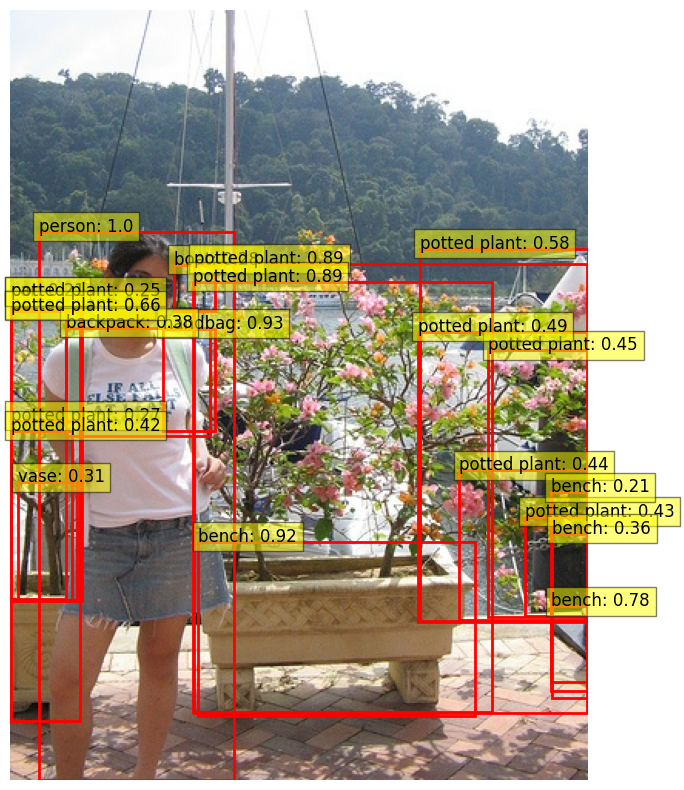

In [27]:

import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load image
img_path = "/kaggle/working/VOCdevkit/VOC2007/JPEGImages/000073.jpg"
image = Image.open(img_path).convert("RGB")

# Load pretrained model and processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
model.eval()

# Preprocess
inputs = processor(images=image, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Postprocess
target_sizes = torch.tensor([image.size[::-1]])  # (height, width)
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.2)[0]

# Visualize
fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    xmin, ymin, xmax, ymax = box
    ax.add_patch(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   linewidth=2, edgecolor='red', facecolor='none'))
    text = f"{model.config.id2label[label.item()]}: {round(score.item(), 2)}"
    ax.text(xmin, ymin, text, fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
plt.axis("off")
plt.show()



Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


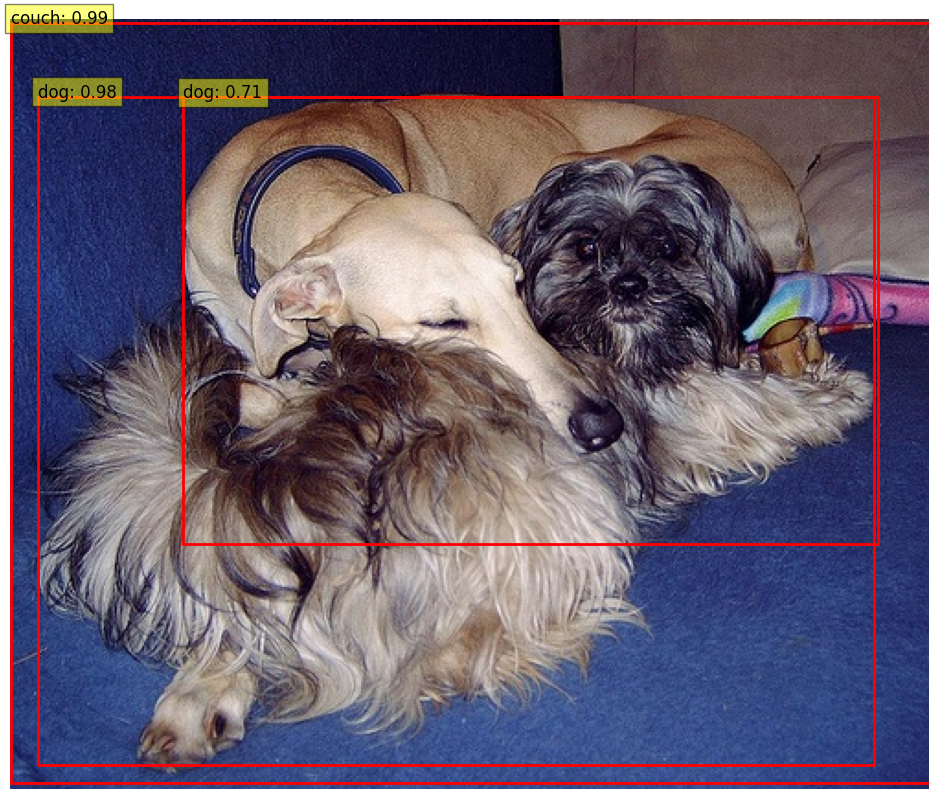

In [28]:

import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load image
img_path = "/kaggle/working/VOCdevkit/VOC2007/JPEGImages/000078.jpg"
image = Image.open(img_path).convert("RGB")

# Load pretrained model and processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
model.eval()

# Preprocess
inputs = processor(images=image, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Postprocess
target_sizes = torch.tensor([image.size[::-1]])  # (height, width)
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.2)[0]

# Visualize
fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    xmin, ymin, xmax, ymax = box
    ax.add_patch(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   linewidth=2, edgecolor='red', facecolor='none'))
    text = f"{model.config.id2label[label.item()]}: {round(score.item(), 2)}"
    ax.text(xmin, ymin, text, fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
plt.axis("off")
plt.show()



Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


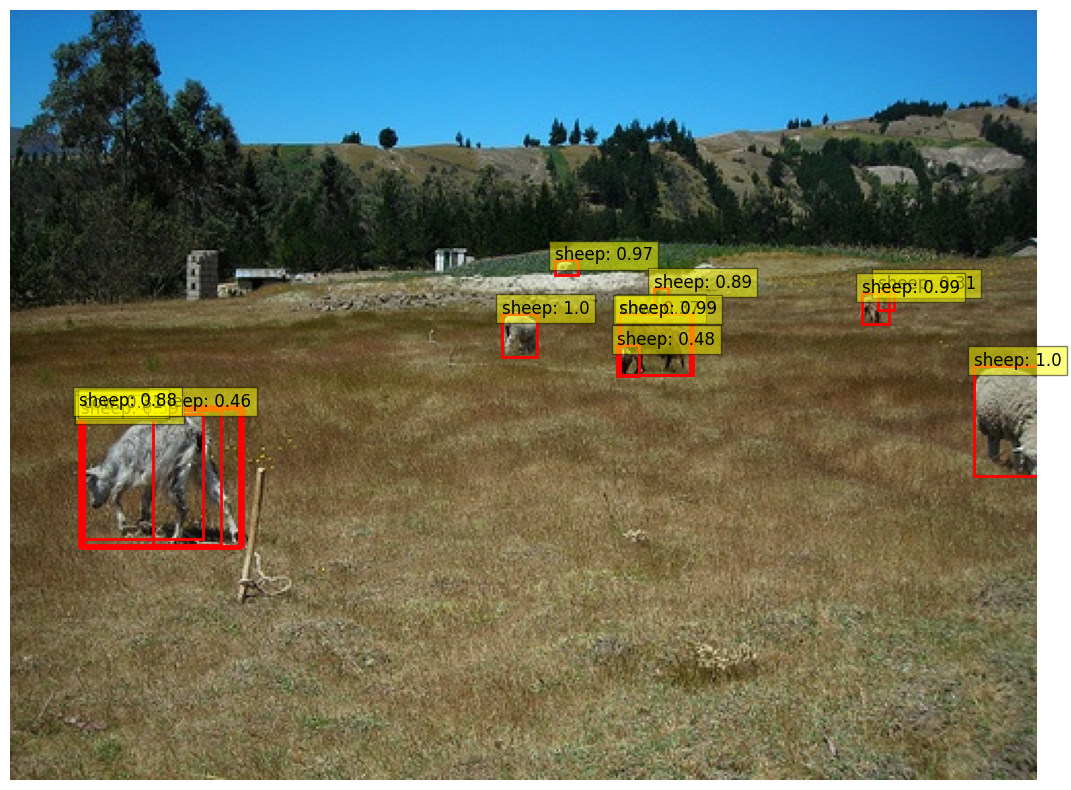

In [30]:

import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load image
img_path = "/kaggle/working/VOCdevkit/VOC2007/JPEGImages/000107.jpg"
image = Image.open(img_path).convert("RGB")

# Load pretrained model and processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
model.eval()

# Preprocess
inputs = processor(images=image, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Postprocess
target_sizes = torch.tensor([image.size[::-1]])  # (height, width)
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.2)[0]

# Visualize
fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    xmin, ymin, xmax, ymax = box
    ax.add_patch(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   linewidth=2, edgecolor='red', facecolor='none'))
    text = f"{model.config.id2label[label.item()]}: {round(score.item(), 2)}"
    ax.text(xmin, ymin, text, fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
plt.axis("off")
plt.show()



Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


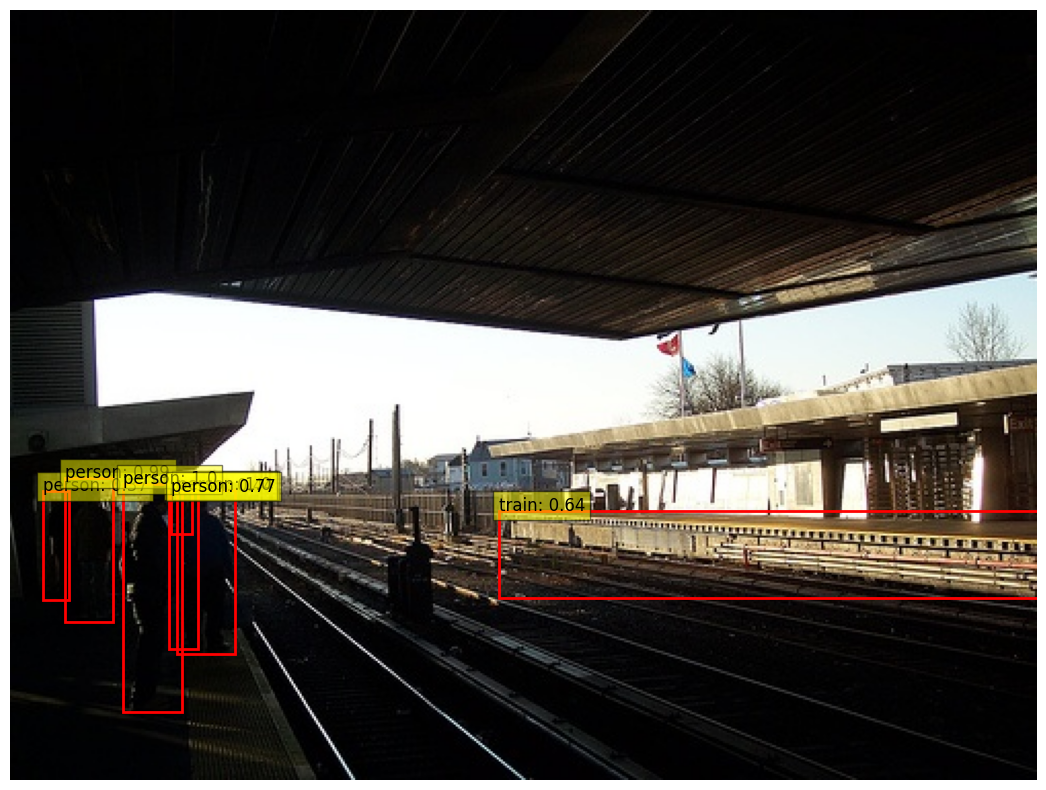

In [31]:

import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load image
img_path = "/kaggle/working/VOCdevkit/VOC2007/JPEGImages/000110.jpg"
image = Image.open(img_path).convert("RGB")

# Load pretrained model and processor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
model.eval()

# Preprocess
inputs = processor(images=image, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Postprocess
target_sizes = torch.tensor([image.size[::-1]])  # (height, width)
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.2)[0]

# Visualize
fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    xmin, ymin, xmax, ymax = box
    ax.add_patch(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   linewidth=2, edgecolor='red', facecolor='none'))
    text = f"{model.config.id2label[label.item()]}: {round(score.item(), 2)}"
    ax.text(xmin, ymin, text, fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))
plt.axis("off")
plt.show()



In [20]:
# # Attention Visualization
# with torch.no_grad():
#     outputs = model(pixel_values=pixel_values)
#     attention = outputs.attentions
# layer = 11
# head = 0
# attention_weights = attention[layer][0, head].cpu().numpy()
# attention_weights = (attention_weights - attention_weights.min()) / (attention_weights.max() - attention_weights.min())
# plt.imshow(attention_weights, cmap='viridis')
# plt.colorbar()
# plt.title(f"Attention Map - Layer {layer}, Head {head}")
# plt.show()
